## Import Libraries

In [274]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

%matplotlib inline


## Load the Data

In [275]:
df = pd.read_csv("cleaned.csv")

In [276]:
df.shape

(5745, 19)

In [277]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000
1,8,Manchester United,Defender Centre-Back,186.0,21.0,34,0.0,0.0,0.130529,0.0,0.0,0.000000,0.000000,2758,47,13,0,2000000,2000000


## Preprocess the Data

#### Split the data into categorical and numerical

In [278]:
numeric_features = ['height', 'age', 'appearance', 'goals',
       'assists', 'yellow cards', 'second yellow cards', 'red cards',
       'goals conceded', 'clean sheets', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value']
categorical_features = ['team', 'position']

In [279]:
for i in categorical_features: # checking outliers in categorical features
    print(df[i].value_counts())

team
FC Volendam                         30
1.FC Köln                           28
Orlando Pirates                     27
Kasimpasa                           27
FC Utrecht                          26
                                    ..
América Futebol Clube (MG)           2
Grêmio Foot-Ball Porto Alegrense     2
Coritiba Foot Ball Club              2
CA Huracán                           1
Goiás Esporte Clube                  1
Name: count, Length: 373, dtype: int64
position
Defender Centre-Back          1006
midfield-CentralMidfield       666
Attack Centre-Forward          644
Goalkeeper                     558
Defender Right-Back            522
midfield-DefensiveMidfield     479
Defender Left-Back             473
Attack-RightWinger             430
midfield-AttackingMidfield     420
Attack-LeftWinger              389
midfield-RightMidfield          57
midfield-LeftMidfield           49
Attack-SecondStriker            37
midfield                         6
Defender                    

In [280]:
df.shape

(5745, 19)

In [281]:
# Counts each value in team
type_counts = df['team'].value_counts()

# removes each value that is under 2
df = df[df['team'].isin(type_counts[type_counts >= 2].index)]

In [282]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000
1,8,Manchester United,Defender Centre-Back,186.0,21.0,34,0.0,0.0,0.130529,0.0,0.0,0.000000,0.000000,2758,47,13,0,2000000,2000000


In [283]:
df.shape

(5743, 19)

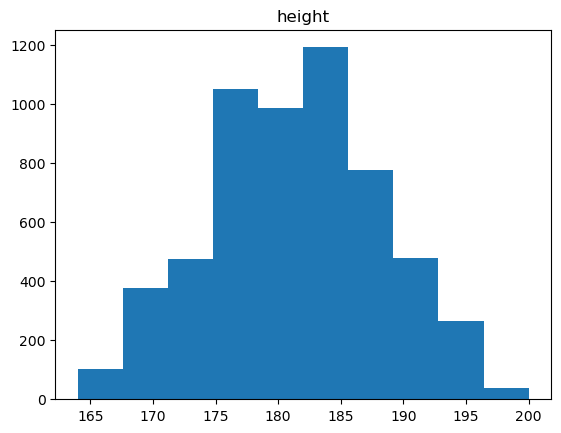

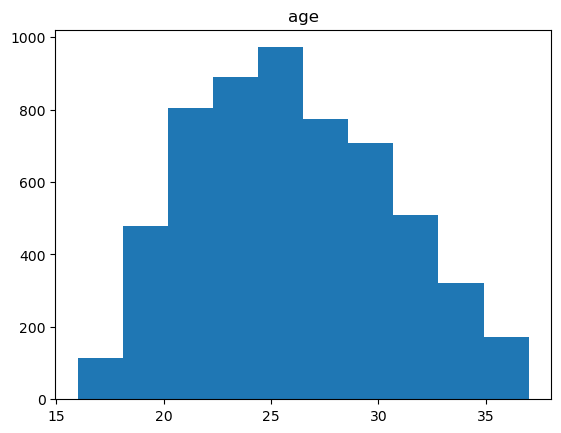

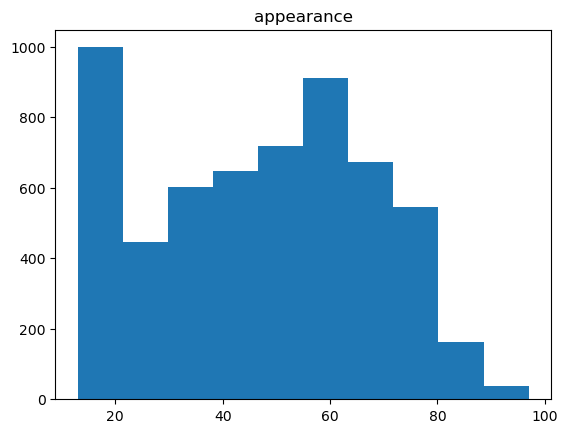

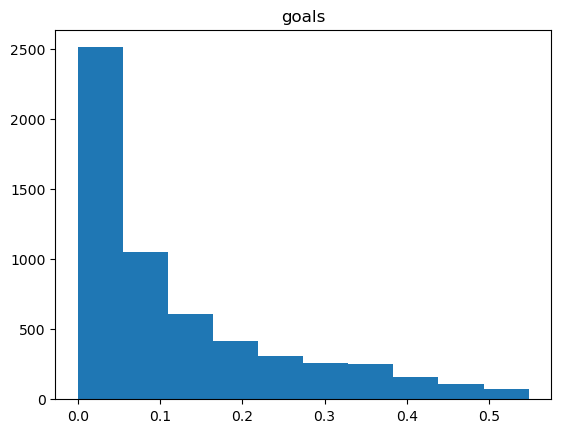

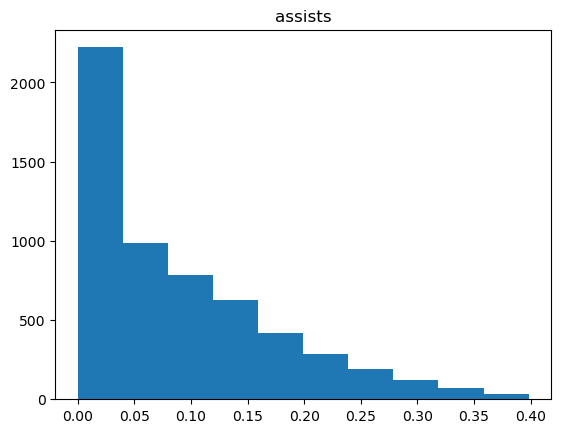

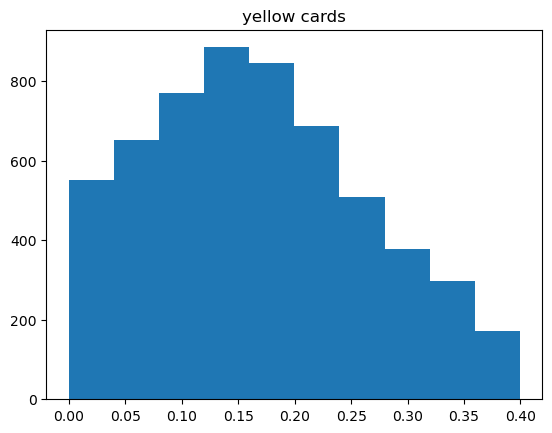

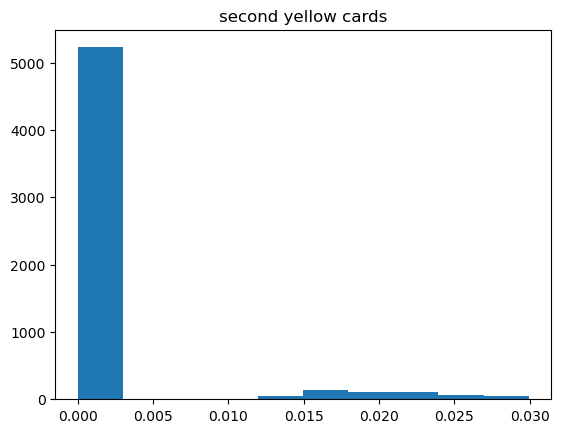

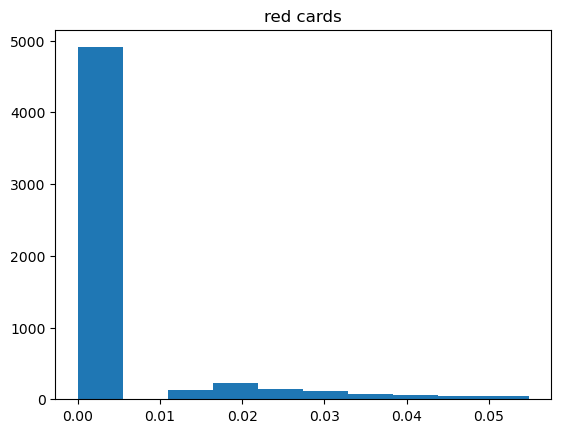

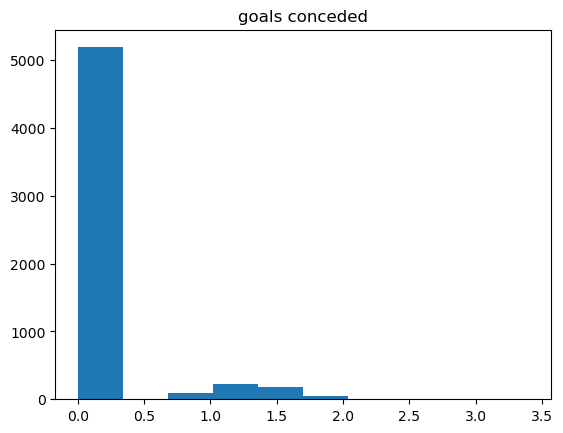

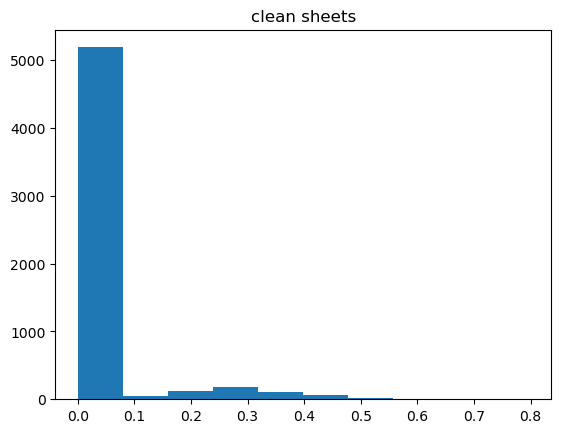

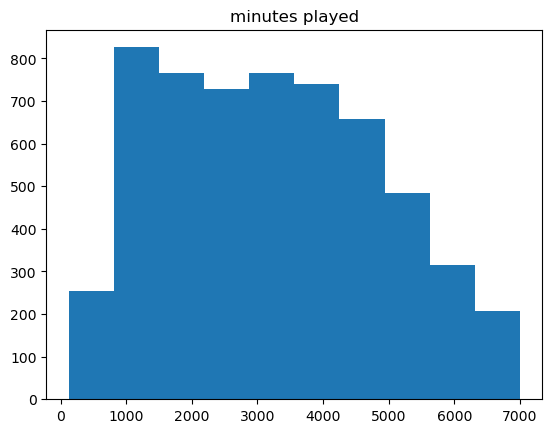

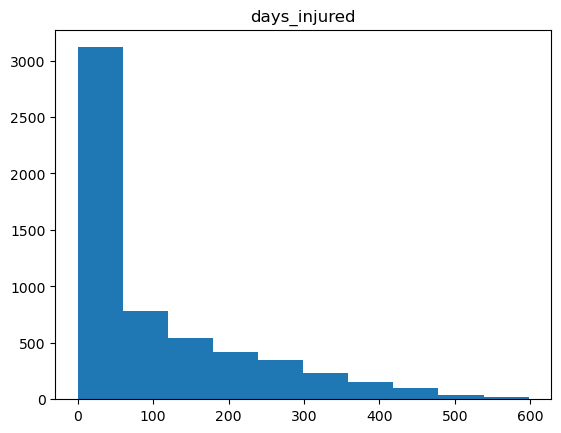

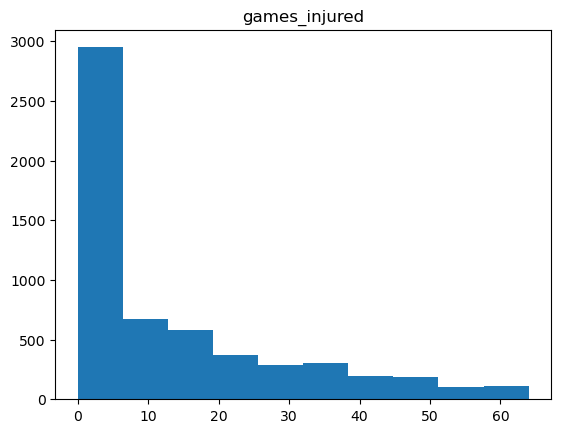

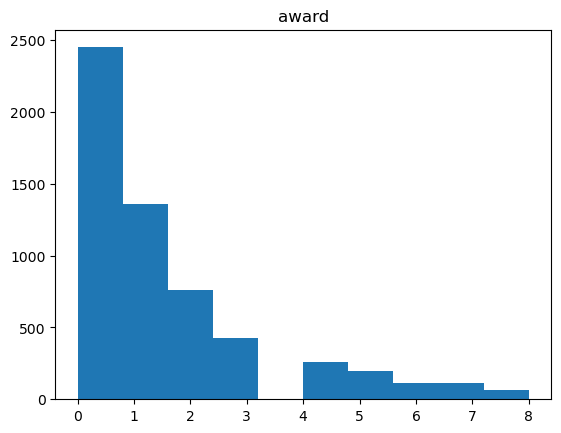

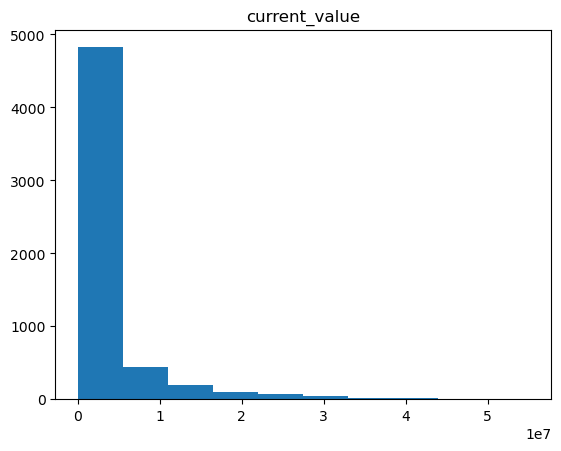

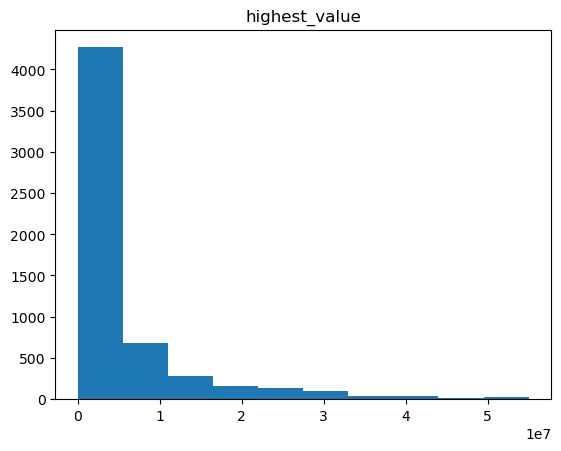

In [284]:
for i in numeric_features: # histogram for each numerical feature 
    plt.hist(df[i])
    plt.title(i)
    plt.show()

In [285]:
categorical_features


['team', 'position']

In [286]:
p35 = df["current_value"].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize current_value
def categorize_price(val):
    if val < p35:
        return 'Low value'
    elif val < p75:
        return 'Mid value'
    else:
        return 'High value'

# Apply the function to create a new column
df['current_value_cat'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['current_value_cat'].value_counts())


current_value_cat
Mid value     2402
Low value     1902
High value    1439
Name: count, dtype: int64


In [287]:
df.drop("Unnamed: 0", inplace=True, axis=1) # removes the column unnamed



In [288]:
df.head() # here we can see that it is removed

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,highest_value,current_value_cat
0,Manchester United,Goalkeeper,196.0,30.0,15,0.000000,0.000000,0.069018,0.0,0.000000,1.242331,0.207055,1304,510,58,1,22000000,Mid value
1,Manchester United,Defender Centre-Back,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.000000,0.000000,0.000000,2758,47,13,0,2000000,Mid value
2,Manchester United,Defender Left-Back,180.0,22.0,34,0.000000,0.033507,0.335071,0.0,0.000000,0.000000,0.000000,2686,175,28,1,12000000,High value
3,Manchester United,Defender Right-Back,183.0,24.0,72,0.032293,0.048439,0.226050,0.0,0.000000,0.000000,0.000000,5574,328,49,3,35000000,High value
4,Manchester United,Defender Right-Back,183.0,25.0,60,0.000000,0.018817,0.094083,0.0,0.018817,0.000000,0.000000,4783,126,20,1,40000000,High value


In [289]:
encoder = LabelEncoder() # as we can see this will encode the current_value_cat to give each value a numeric representation and a weight
df["current_value_cat_encoded"] = encoder.fit_transform(df['current_value_cat'])
df.drop('current_value_cat', axis=1, inplace=True)
df = pd.get_dummies(df, columns=categorical_features) # here we made dummies for each categorical features

In [290]:
df.shape

for i in df.columns:# check if everything is in place
    print(i)

height
age
appearance
goals
assists
yellow cards
second yellow cards
red cards
goals conceded
clean sheets
minutes played
days_injured
games_injured
award
highest_value
current_value_cat_encoded
team_1.FC Köln
team_1.FC Union Berlin
team_1.FSV Mainz 05
team_AA Argentinos Juniors
team_AC Ajaccio
team_AC Milan
team_AC Monza
team_ACF Fiorentina
team_AFC Bournemouth
team_AJ Auxerre
team_AS Monaco
team_AS Roma
team_AZ Alkmaar
team_Abha Club
team_Adana Demirspor
team_Adelaide United
team_Ajax Amsterdam
team_Akhmat Grozny
team_Al-Adalah FC
team_Al-Batin FC
team_Al-Fateh SC
team_Al-Fayha FC
team_Al-Hilal Saudi FC
team_Al-Ittihad Club (Jeddah)
team_Al-Khaleej
team_Al-Nassr FC
team_Al-Raed SFC
team_Al-Shabab Club (Riyadh)
team_Al-Taawoun FC
team_Al-Tai
team_Al-Wehda FC
team_Alanyaspor
team_Albirex Niigata
team_AmaZulu FC
team_América Futebol Clube (MG)
team_Angers SCO
team_Antalyaspor
team_Arsenal FC
team_Arsenal Fútbol Club
team_Aston Villa
team_Atalanta BC
team_Athletic Bilbao
team_Atlanta Uni

In [291]:
df.head(2)


,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,...,False,False,False,True,False,False,False,False,False,False
1,186.0,21.0,34,0.0,0.0,0.130529,0.0,0.0,0.000000,0.000000,...,True,False,False,False,False,False,False,False,False,False


In [292]:
correlation = df.corr() # here we can see the correllation for every feature with current_value_cat_encoded
print(correlation["current_value_cat_encoded"].sort_values(ascending=False))

current_value_cat_encoded    1.000000
age                          0.121400
team_Atlético de San Luis    0.050396
team_Club Necaxa             0.048650
team_FC Famalicão            0.046707
                               ...   
team_Southampton FC         -0.090464
award                       -0.094580
minutes played              -0.207444
appearance                  -0.222659
highest_value               -0.493388
Name: current_value_cat_encoded, Length: 403, dtype: float64


In [293]:
threshold = 0.01 # we have set the threshold to 0.01 after experementing with multiple thresholds 

selected_features = correlation[abs(correlation['current_value_cat_encoded']) > threshold]['current_value_cat_encoded'].index
selected_features # here we have filtered the correlation with the threshold that we have set

Index(['height', 'age', 'appearance', 'goals', 'assists',
       'second yellow cards', 'goals conceded', 'clean sheets',
       'minutes played', 'days_injured',
       ...
       'team_Wolverhampton Wanderers', 'team_Yokohama F. Marinos',
       'position_Attack-SecondStriker', 'position_Defender Centre-Back',
       'position_Goalkeeper', 'position_midfield-AttackingMidfield',
       'position_midfield-CentralMidfield',
       'position_midfield-DefensiveMidfield', 'position_midfield-LeftMidfield',
       'position_midfield-RightMidfield'],
      dtype='object', length=278)

#### 4. Prepare train and test data

In [294]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42) # random over sampler to balance the data for better results


In [295]:
# Prepare data
X = df.drop(['current_value_cat_encoded'], axis=1)
y = df['current_value_cat_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)# fitted the over sampler


In [296]:
model = LogisticRegression()

In [297]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],   
    'max_iter': [25, 50],
    'n_jobs': [5]

}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=10,
                           scoring='f1_macro', 
                           verbose=1,
                           n_jobs = 5)


In [298]:
X.shape

(5743, 402)

In [299]:
# Fit the model on the training data
grid_search.fit(X_train_resampled, y_train_resampled )

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=5,
             param_grid={'max_iter': [25, 50], 'n_jobs': [5],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='f1_macro', verbose=1)

In [300]:
grid_search.best_params_ # these are the best parameters that the gred search used

{'max_iter': 25, 'n_jobs': 5, 'penalty': 'l2', 'solver': 'lbfgs'}

In [301]:
y_pred = grid_search.predict(X_test_scaled)
y_pred_train = grid_search.predict(X_train_scaled)


Classification Report of Training:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1149
           1       0.78      0.84      0.81      1528
           2       0.81      0.72      0.76      1917

    accuracy                           0.81      4594
   macro avg       0.81      0.82      0.82      4594
weighted avg       0.81      0.81      0.81      4594

Classification Report of Testing:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       290
           1       0.71      0.82      0.76       374
           2       0.75      0.65      0.70       485

    accuracy                           0.75      1149
   macro avg       0.76      0.77      0.76      1149
weighted avg       0.76      0.75      0.75      1149

Confusion Matrix:


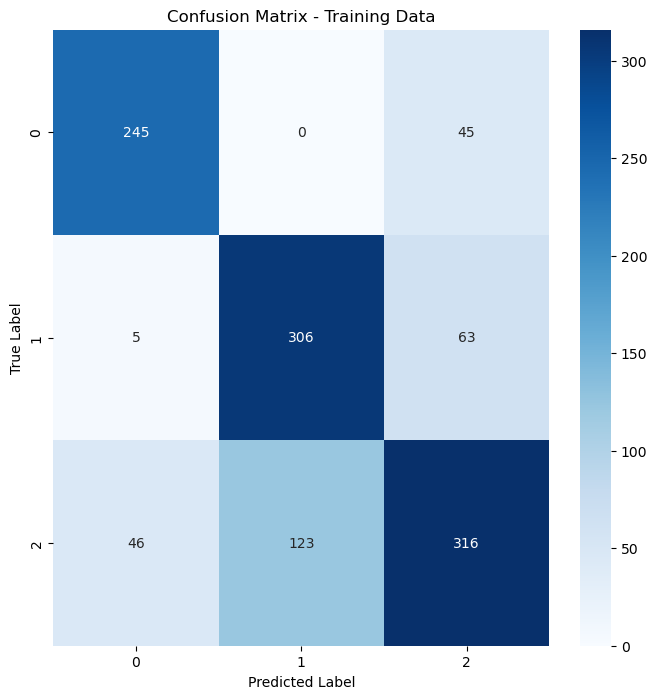

In [303]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

print("Classification Report of Training:")# Print the classification report and confusion matrix
print(classification_report(y_train, y_pred_train))

print("Classification Report of Testing:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
conf_matrix_test = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()